<a href="https://colab.research.google.com/github/alice202122/2competitionDL/blob/main/vanilla_provacrossval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


### Import libraries

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


### Set seed for reproducibility

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Exploration Data Analysis (EDA)
#### Meme 


Load the dataset

In [ ]:
dataset = pd.read_csv('Training.csv').dropna().astype(np.float32)

print(dataset.shape)
dataset.head()
#snow and rain are incremental: for how long it's going to rain or snaw

OSError: ignored

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68528 entries, 0 to 68527
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68528 non-null  float32
 1   Wonder level        68528 non-null  float32
 2   Crunchiness         68528 non-null  float32
 3   Loudness on impact  68528 non-null  float32
 4   Meme creativity     68528 non-null  float32
 5   Soap slipperiness   68528 non-null  float32
 6   Hype root           68528 non-null  float32
dtypes: float32(7)
memory usage: 2.4 MB


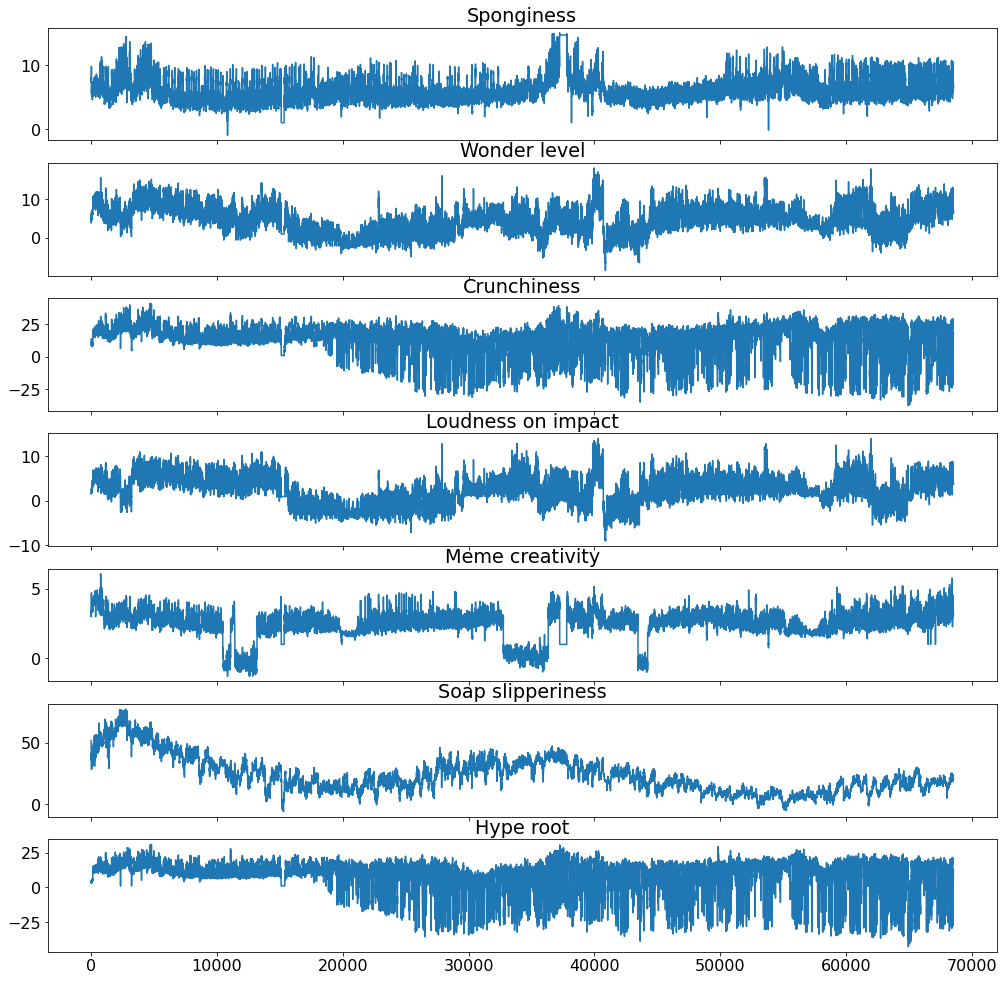

In [ ]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
inspect_dataframe(dataset, dataset.columns)

Sequential Train-Test split and normalization

multivariate forecasting: we are going to predict all these 7 dimensions
we want to predict what there is in the future, for a good prediction after the training best epoch
retrian the model also on test. the test is just a split u have dobne for your purposes.
but in the test there is the higher amount of info we can access. 
how to cross validate? if i do the split and i predict in a shuffled way it may happen in case of no stationary time series, the many info are in the part we don't want to take as training info. 


##CROSS VALIDATION SPLITTING IN 4 FOLDERS


In [ ]:
dataset.shape

(68528, 7)

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
#Specify fold and perform splitting
tscv = TimeSeriesSplit(n_splits=4)
tscv.split(dataset)

<generator object TimeSeriesSplit.split at 0x7f135e329250>

In [ ]:
#Find out no of observations in train and test sets
i=0
for train, test in tscv.split(dataset):
    i=i+1
    print ("No of observations under train%s=%s" % (i, len(train)))
    print ("No of observations under test%s=%s" % (i, len(test)))

No of observations under train1=13708
No of observations under test1=13705
No of observations under train2=27413
No of observations under test2=13705
No of observations under train3=41118
No of observations under test3=13705
No of observations under train4=54823
No of observations under test4=13705


In [ ]:
train1, test1 = dataset.iloc[:13708, :], dataset.iloc[13708:27413, :]
train2, test2 = dataset.iloc[:27413,: ], dataset.iloc[27413:41118,:]
train3, test3 = dataset.iloc[:41118, :], dataset.iloc[41118:54823, :]
train4, test4 = dataset.iloc[:54823,: ], dataset.iloc[54823:68528, :]
print(train1.shape, test1.shape)
print(train2.shape, test2.shape)
print(train3.shape, test3.shape)
print(train4.shape, test4.shape)


(13708, 7) (13705, 7)
(27413, 7) (13705, 7)
(41118, 7) (13705, 7)
(54823, 7) (13705, 7)


Normalization of the data

In [ ]:
# Normalize both features and labels
#train1 test1
X1_min = train1.min()
X1_max = train1.max()

train1 = (train1-X1_min)/(X1_max-X1_min)
test1 = (test1-X1_min)/(X1_max-X1_min)

#train2 test2
X2_min = train2.min()
X2_max = train2.max()

train2 = (train2-X2_min)/(X2_max-X2_min)
test2 = (test2-X2_min)/(X2_max-X2_min)

#train3 test3
X3_min = train3.min()
X3_max = train3.max()

train3 = (train3-X3_min)/(X3_max-X3_min)
test3 = (test3-X3_min)/(X3_max-X3_min)

#train4 test4
X4_min = train4.min()
X4_max = train4.max()

train4 = (train4-X4_min)/(X4_max-X4_min)
test4 = (test4-X4_min)/(X4_max-X4_min)



In [ ]:
train1.shape

(13708, 7)

In [ ]:
window = 200
stride = 10 #random numbers

In [ ]:
#in order to properly choose the window which data should I take?
future = test4[-window:] #we take the last window and we predict starting from these
future = (future-X4_min)/(X4_max-X4_min)
future = np.expand_dims(future, axis=0)
future.shape


(1, 200, 7)

In [ ]:
#telescope argument= how many time points we want to predict.
#we start by looking at the previous 100 points
def build_sequences(df, target_labels=['Sponginess'], window=200, stride=10, telescope=864):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = [] #we create 2 lists
    labels = []
    temp_df = df.copy().values#our x variable
    temp_label = df[target_labels].copy().values #the label can be one singole column, a subset of the entrie set of columns or all the columns
    padding_len = len(df)%window

    if(padding_len != 0): 
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float32')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float32')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

# direct model


In [ ]:
target_labels = dataset.columns
telescope = 864


In [ ]:
X1_train, y1_train = build_sequences(train1, target_labels, window, stride, telescope)
X1_test, y1_test = build_sequences(test1, target_labels, window, stride, telescope)
#we apply thenext functions to both test and train
X1_train.shape, y1_train.shape, X1_test.shape, y1_test.shape

((1274, 200, 7), (1274, 864, 7), (1274, 200, 7), (1274, 864, 7))

In [ ]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X1_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

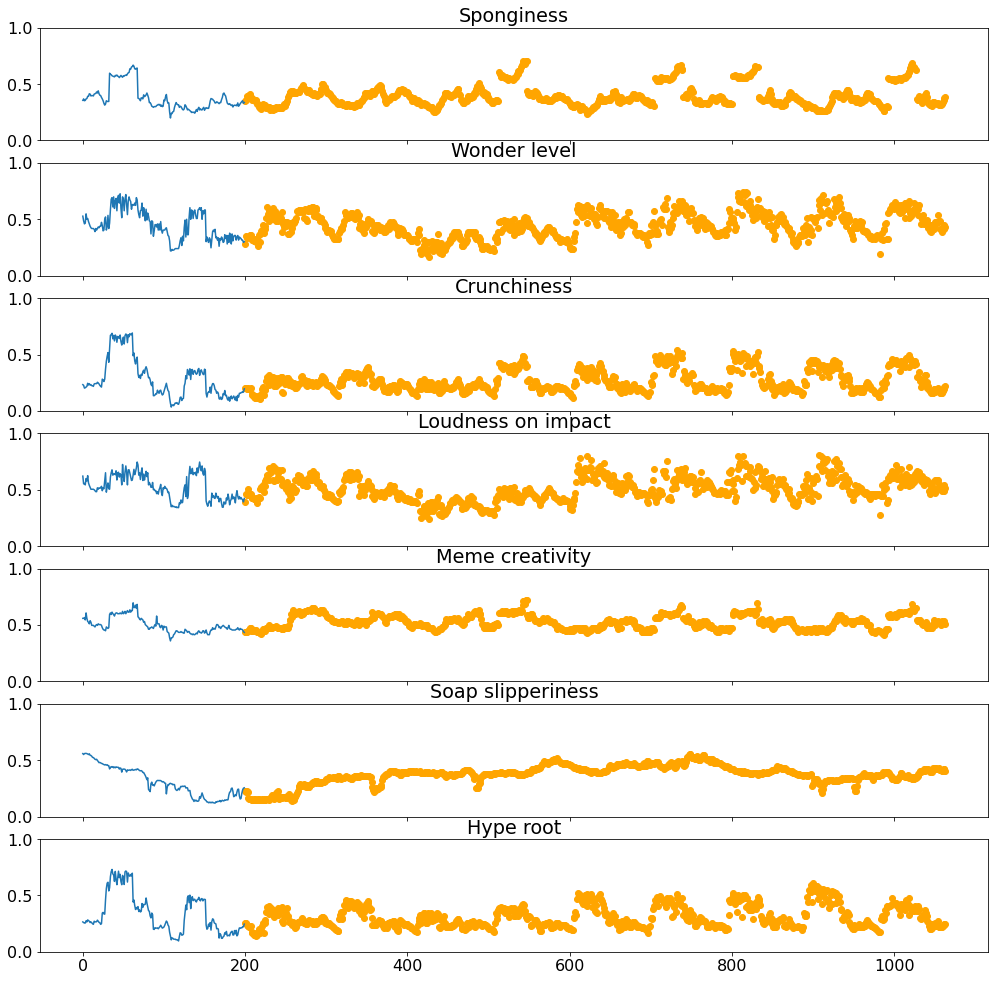

In [ ]:
inspect_multivariate(X1_train, y1_train, target_labels, telescope)

In [ ]:
input_shape = X1_train.shape[1:]
output_shape = y1_train.shape[1:]
batch_size = 64
epochs = 200

In [ ]:
from pandas.core.dtypes.cast import convert_dtypes
#merge convolution and recurrent networks
def build_CONV_LSTM_model(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    

    lstm = tfkl.LSTM(128, return_sequences=True)(input_layer)
    lstm = tfkl.LSTM(128)(lstm)
    dropout = tfkl.Dropout(.3, seed=seed)(lstm)

    dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(dropout)
    #attention_layer = attention()(dense)

    #try without dense
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)
    #this could be the last layer
    output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)
    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])
    #try different errors

    # Return the model
    return model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 200, 7)]          0         
                                                                 
 lstm (LSTM)                 (None, 200, 128)          69632     
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 6048)              780192    
                                                                 
 reshape (Reshape)           (None, 864, 7)            0         
                                                                 
 conv1d (Conv1D)             (None, 864, 7)            56    

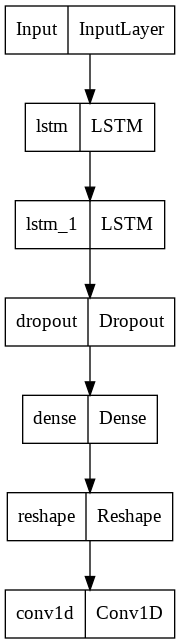

In [ ]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

In [ ]:
# Train the model
history = model.fit(
    x = X1_train,
    y = y1_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.2,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
16/16 [==============================] - 16s 163ms/step - loss: 0.1722 - mae: 0.3551 - val_loss: 0.0941 - val_mae: 0.2520 - lr: 0.0010
Epoch 2/200
16/16 [==============================] - 1s 85ms/step - loss: 0.0970 - mae: 0.2472 - val_loss: 0.0861 - val_mae: 0.2471 - lr: 0.0010
Epoch 3/200
16/16 [==============================] - 1s 85ms/step - loss: 0.0732 - mae: 0.2129 - val_loss: 0.0702 - val_mae: 0.2194 - lr: 0.0010
Epoch 4/200
16/16 [==============================] - 1s 85ms/step - loss: 0.0551 - mae: 0.1835 - val_loss: 0.0636 - val_mae: 0.2027 - lr: 0.0010
Epoch 5/200
16/16 [==============================] - 1s 85ms/step - loss: 0.0424 - mae: 0.1599 - val_loss: 0.0556 - val_mae: 0.1879 - lr: 0.0010
Epoch 6/200
16/16 [==============================] - 1s 85ms/step - loss: 0.0345 - mae: 0.1438 - val_loss: 0.0535 - val_mae: 0.1859 - lr: 0.0010
Epoch 7/200
16/16 [==============================] - 1s 85ms/step - loss: 0.0310 - mae: 0.1376 - val_loss: 0.0571 - val_mae: 0.1

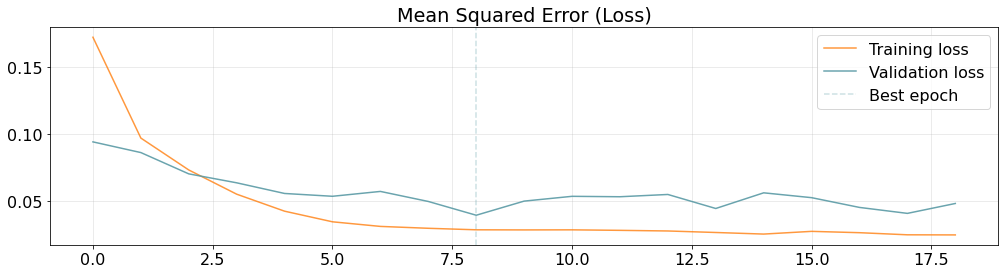

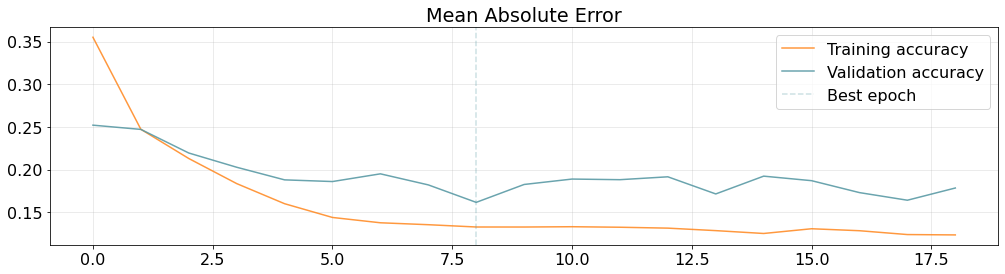

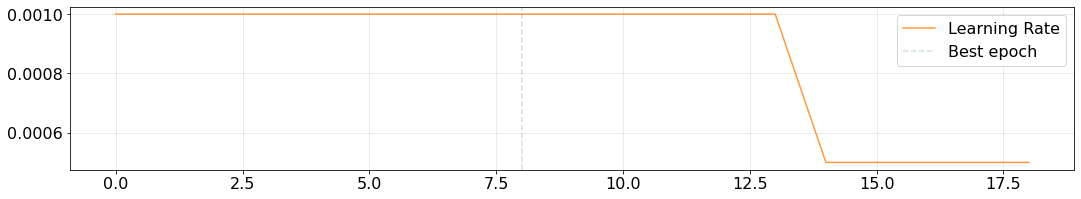

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
# Predict the test set 
predictions = model.predict(X1_test)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y1_test.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y1_test.flatten(),predictions.flatten())
mean_squared_error, mean_absolute_error

(1274, 864, 7)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.07679578>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.21231663>)

In [ ]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X1_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X1_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

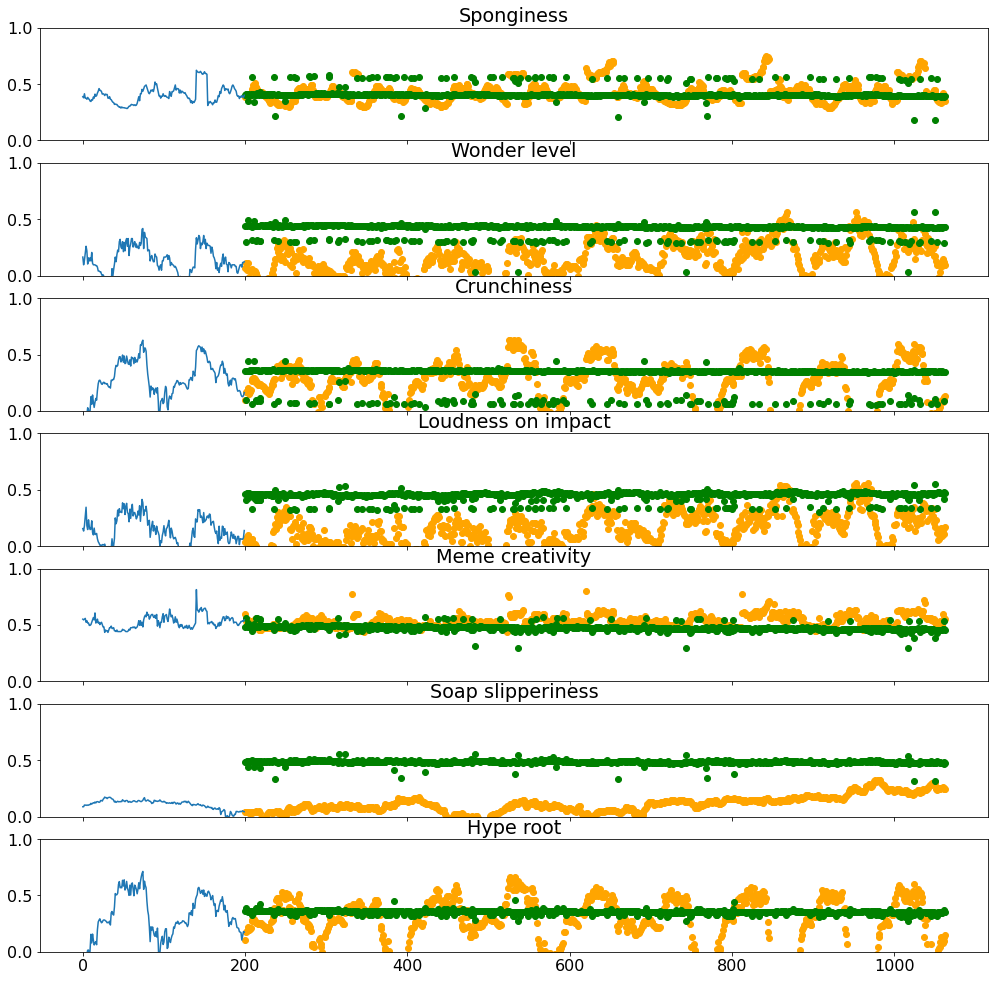

In [ ]:
inspect_multivariate_prediction(X1_test, y1_test, predictions, target_labels, telescope)

In [ ]:
maes = []
for i in range(predictions.shape[1]):
    ft_maes = []
    for j in range(predictions.shape[2]):
        ft_maes.append(np.mean(np.abs(y1_test[:,i,j]-predictions[:,i,j]), axis=0))
    ft_maes = np.array(ft_maes)
    maes.append(ft_maes)
maes = np.array(maes)

In [ ]:
future_predictions = model.predict(future)

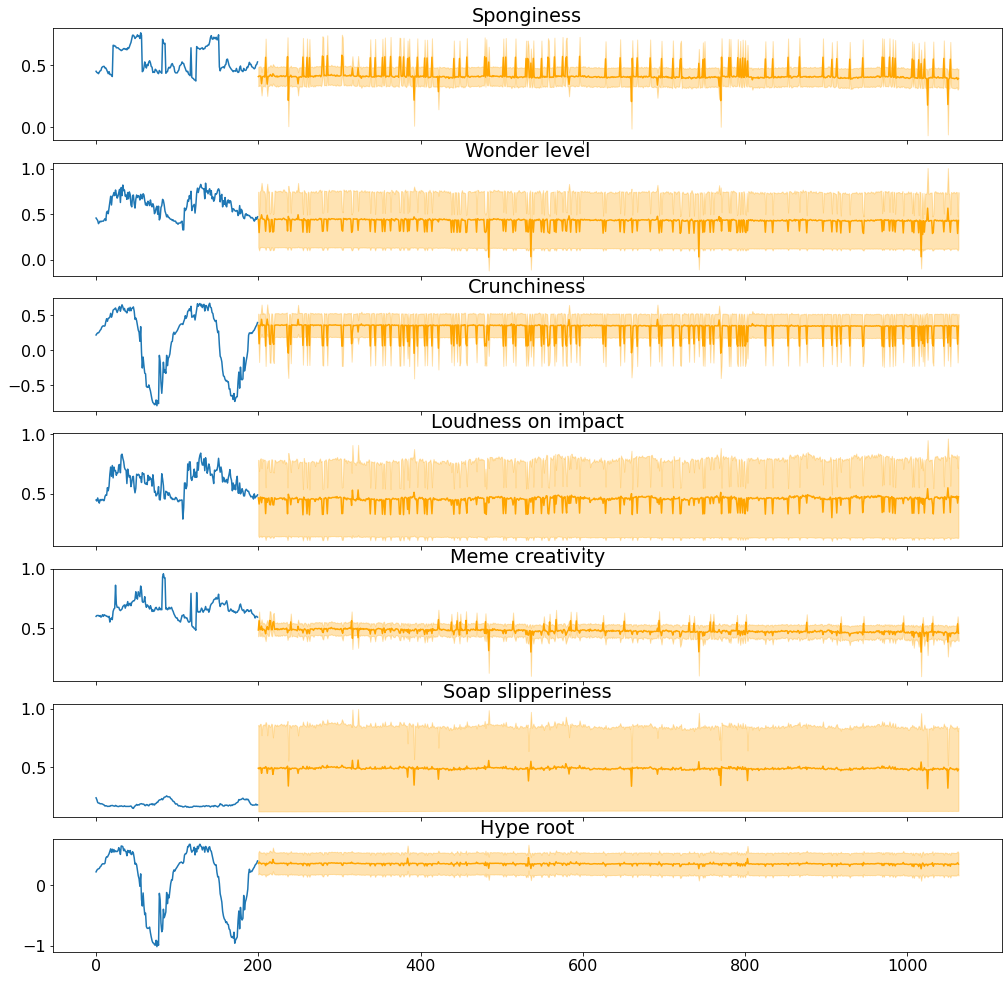

In [ ]:
figs, axs = plt.subplots(len(target_labels), 1, sharex=True, figsize=(17,17))
for i, col in enumerate(target_labels):
    axs[i].plot(np.arange(len(future[0,:,i])), future[0,:,i])
    axs[i].plot(np.arange(len(future[0,:,i]), len(future[0,:,i])+telescope), future_predictions[0,:,i], color='orange')
    axs[i].fill_between(
        np.arange(len(future[0,:,i]), len(future[0,:,i])+telescope), 
        future_predictions[0,:,i]+maes[:,i], 
        future_predictions[0,:,i]-maes[:,i], 
        color='orange', alpha=.3)
    axs[i].set_title(col)
    # axs[i].set_ylim(0,1)
plt.show()
#our window could be larger and our telescope is too large

In [ ]:
model_directory= '/content/drive/MyDrive/Colab Notebooks'
filename = 'vanilla_attent1_try'
filename_chosen = os.path.join(model_directory, filename)
model.save(filename_chosen + '.h5')